In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_moons, make_circles

In [2]:
def euclidean_distance (point1, point2):
    """Computes the Euclidean distance between two points."""
    return np.sqrt(np.sum((point1 - point2)**2))

In [3]:
def gaussian_kernel (distance, bandwidth):
    """Computes the Gaussian kernel value."""
    return np.exp(-0.5 * (distance / bandwidth) ** 2)

In [4]:
def flat_kernel (distance, bandwidth):
    """Computes the Flat/Uniform kernel value."""
    if distance <= bandwidth:
        return 1.0
    else:
        return 0.0

In [5]:
def _initialize_point_weights (point_weights_param, num_total_points):
    """Validates and prepares effective point weights."""
    if point_weights_param is None:
        return np.ones(num_total_points)
    else:
        return point_weights_param

In [6]:
def _calculate_one_shift_step (
    current_point_in_trajectory,
    all_original_data_points,
    all_effective_point_weights,
    bandwidth,
    kernel_name,
    batch_size
):
    """Calculates one mean shift update (new position) for the current_point_in_trajectory."""
    n_total_points_original = all_original_data_points.shape[0]
    numerator = np.zeros_like(current_point_in_trajectory)
    denominator = 0.0

    # Determine points to use for density estimation (all or minibatch)
    if batch_size is not None and 0 < batch_size < n_total_points_original:
        batch_indices = np.random.choice(
            n_total_points_original, batch_size, replace=False)
        points_for_density_est = all_original_data_points[batch_indices]
        weights_for_density_points = all_effective_point_weights[batch_indices]
    else:
        points_for_density_est = all_original_data_points
        weights_for_density_points = all_effective_point_weights

    for k_idx, neighbor_point in enumerate(points_for_density_est):
        distance = euclidean_distance(current_point_in_trajectory, neighbor_point)

        kernel_w = 0.0
        if kernel_name == 'gaussian':
            kernel_w = gaussian_kernel(distance, bandwidth)
        elif kernel_name == 'flat':
            kernel_w = flat_kernel(distance, bandwidth)

        intrinsic_w = weights_for_density_points[k_idx]
        combined_weight = kernel_w * intrinsic_w

        if combined_weight > 1e-8:
            numerator += (combined_weight * neighbor_point)
            denominator += combined_weight

    return numerator / denominator

In [7]:
def _shift_point_to_mode (
    initial_point_for_trajectory,
    all_original_data_points,
    all_effective_point_weights,
    bandwidth,
    kernel_name,
    batch_size,
    max_iterations,
    convergence_threshold
):
    """Iteratively shifts an initial_point to its mode."""
    current_point = np.copy(initial_point_for_trajectory)

    for _ in range(max_iterations):
        new_position = _calculate_one_shift_step(
            current_point, all_original_data_points, all_effective_point_weights,
            bandwidth, kernel_name, batch_size
        )

        shift_distance = euclidean_distance(new_position, current_point)
        current_point = new_position

        if shift_distance < convergence_threshold:
            break
    return current_point

In [8]:
def _add_mode_if_new(
    existing_modes_list,
    candidate_mode, bandwidth,
    mode_merge_factor
):
    """
    Checks if candidate_mode is new. If so, appends to existing_modes_list.
    Returns True if added, False otherwise.
    """
    is_new = True
    if existing_modes_list:
        merge_threshold = bandwidth * mode_merge_factor
        for mode in existing_modes_list:
            if euclidean_distance(candidate_mode, mode) < merge_threshold:
                is_new = False
                break
    if is_new:
        existing_modes_list.append(candidate_mode)
    return is_new

In [9]:
def _assign_points_to_modes(original_data_points, modes_array):
    """Assigns each data point to the nearest mode."""
    n_points = original_data_points.shape[0]
    labels = np.zeros(n_points, dtype=int)

    if modes_array.size == 0:
        return np.array([-1] * n_points)

    for i in range(n_points):
        distances_to_modes = [euclidean_distance(original_data_points[i], mode) for mode in modes_array]
        labels[i] = np.argmin(distances_to_modes)
    return labels

In [10]:
def mean_shift_clustering(
    data_points,
    bandwidth,
    kernel_name='gaussian',
    point_weights=None,
    batch_size=None,
    max_iterations_per_point=100,
    convergence_threshold=1e-5,
    mode_merge_threshold_factor=0.5,
    random_seed=None
    ):
    """
    Performs Mean Shift clustering (refactored version).
    Args are the same as the original function.
    Returns:
        np.array: Cluster centers (modes).
        np.array: Labels for each data point.
    """
    n_total_points, _ = data_points.shape

    if random_seed is not None:
        np.random.seed(random_seed)

    # 1. Initialize effective point weights
    effective_point_weights = _initialize_point_weights(point_weights, n_total_points)
    identified_modes_list = []

    # 2. For each data point, shift it to find a mode
    for i in range(n_total_points):
        initial_point = data_points[i]
        converged_mode_candidate = _shift_point_to_mode(
            initial_point, data_points, effective_point_weights,
            bandwidth, kernel_name, batch_size,
            max_iterations_per_point, convergence_threshold
        )

        # 3. Add the converged point to the list of modes if it's new
        _add_mode_if_new(identified_modes_list, converged_mode_candidate,
                         bandwidth, mode_merge_threshold_factor)

    modes_array_final = np.array(identified_modes_list)

    # 4. Assign original data points to the identified modes
    point_labels = _assign_points_to_modes(data_points, modes_array_final)

    return modes_array_final, point_labels

In [11]:
def run_and_plot_mean_shift(
    data,
    bandwidth,
    kernel,
    ax,
    title_prefix,
    point_weights=None,
    batch_size=None,
    random_seed=None
):
    title = f"{title_prefix}\nKernel: '{kernel}', BW: {bandwidth}"
    if batch_size:
        title += f", BS: {batch_size}"
    if point_weights is not None:
        title += ", Weighted"

    cluster_centers, point_labels = mean_shift_clustering(
        data, bandwidth, kernel_name=kernel,
        point_weights=point_weights, batch_size=batch_size,
        random_seed=random_seed
    )

    print(f"Found {len(cluster_centers)} clusters for {title_prefix} with kernel '{kernel}'.")

    unique_labels = np.unique(point_labels)
    cmap_name = 'viridis' if len(unique_labels) > 2 else 'Paired'
    cmap = plt.cm.get_cmap(cmap_name, max(2,len(unique_labels)))

    for k_idx, k_label in enumerate(unique_labels):
        cluster_color = cmap(k_idx / max(1, len(unique_labels)-1)) if k_label != -1 and len(unique_labels) > 1 else cmap(0)
        if k_label == -1 : cluster_color = 'black'
        marker_style = 'o' if k_label != -1 else 'x'

        class_member_mask = (point_labels == k_label)
        xy = data[class_member_mask]
        ax.scatter(xy[:, 0], xy[:, 1], s=50, c=[cluster_color], marker=marker_style, edgecolor='k') # Removed label per point for clarity

    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1], s=280, c='red', marker='P', edgecolor='black', label='Modes')
    ax.set_title(title)
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.legend(loc='best')
    ax.grid(True, linestyle='--', alpha=0.7)


--- Experiment I.A: Well-separated Blobs & Bandwidth Variation ---
Found 3 clusters for BW: 0.5 with kernel 'gaussian'.


<ipython-input-18-d0b8948170f1>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, max(2,len(unique_labels)))


Found 3 clusters for BW: 0.8 with kernel 'gaussian'.
Found 3 clusters for BW: 1.2 with kernel 'gaussian'.
Found 3 clusters for BW: 1.7 with kernel 'gaussian'.
Found 3 clusters for BW: 2.5 with kernel 'gaussian'.
Found 3 clusters for BW: 3.5 with kernel 'gaussian'.


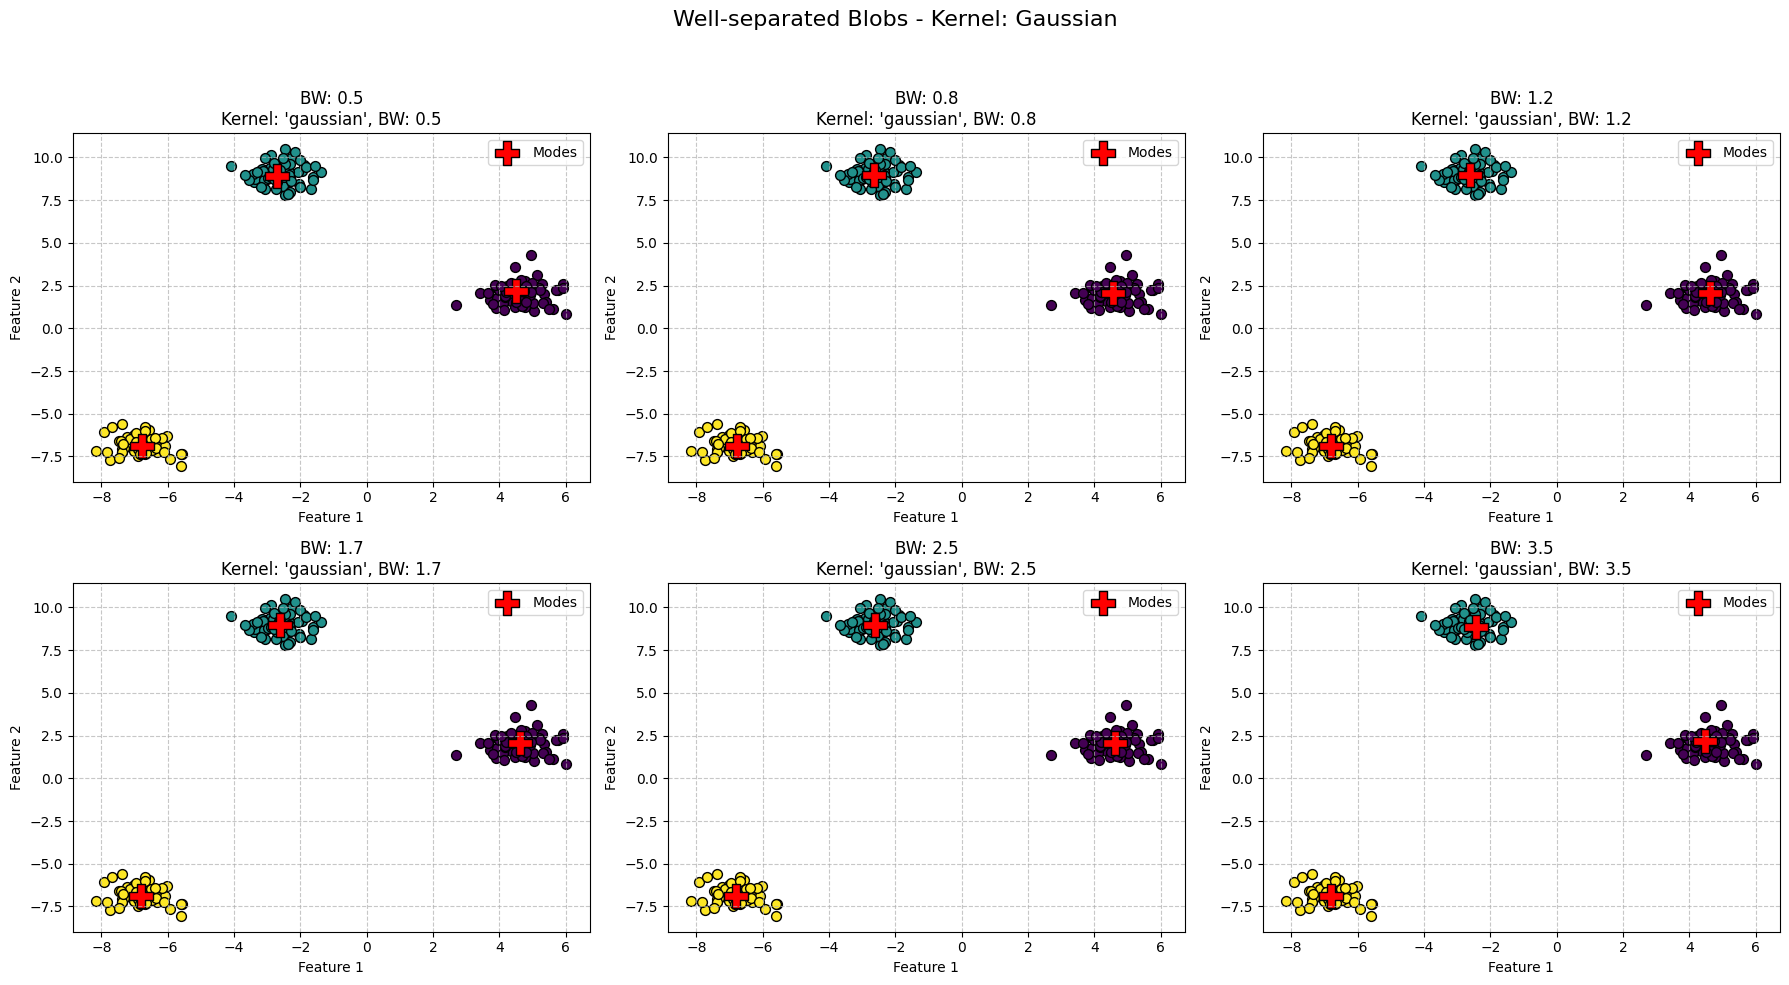

Found 31 clusters for BW: 0.5 with kernel 'flat'.
Found 5 clusters for BW: 0.8 with kernel 'flat'.
Found 3 clusters for BW: 1.2 with kernel 'flat'.
Found 3 clusters for BW: 1.7 with kernel 'flat'.
Found 3 clusters for BW: 2.5 with kernel 'flat'.
Found 3 clusters for BW: 3.5 with kernel 'flat'.


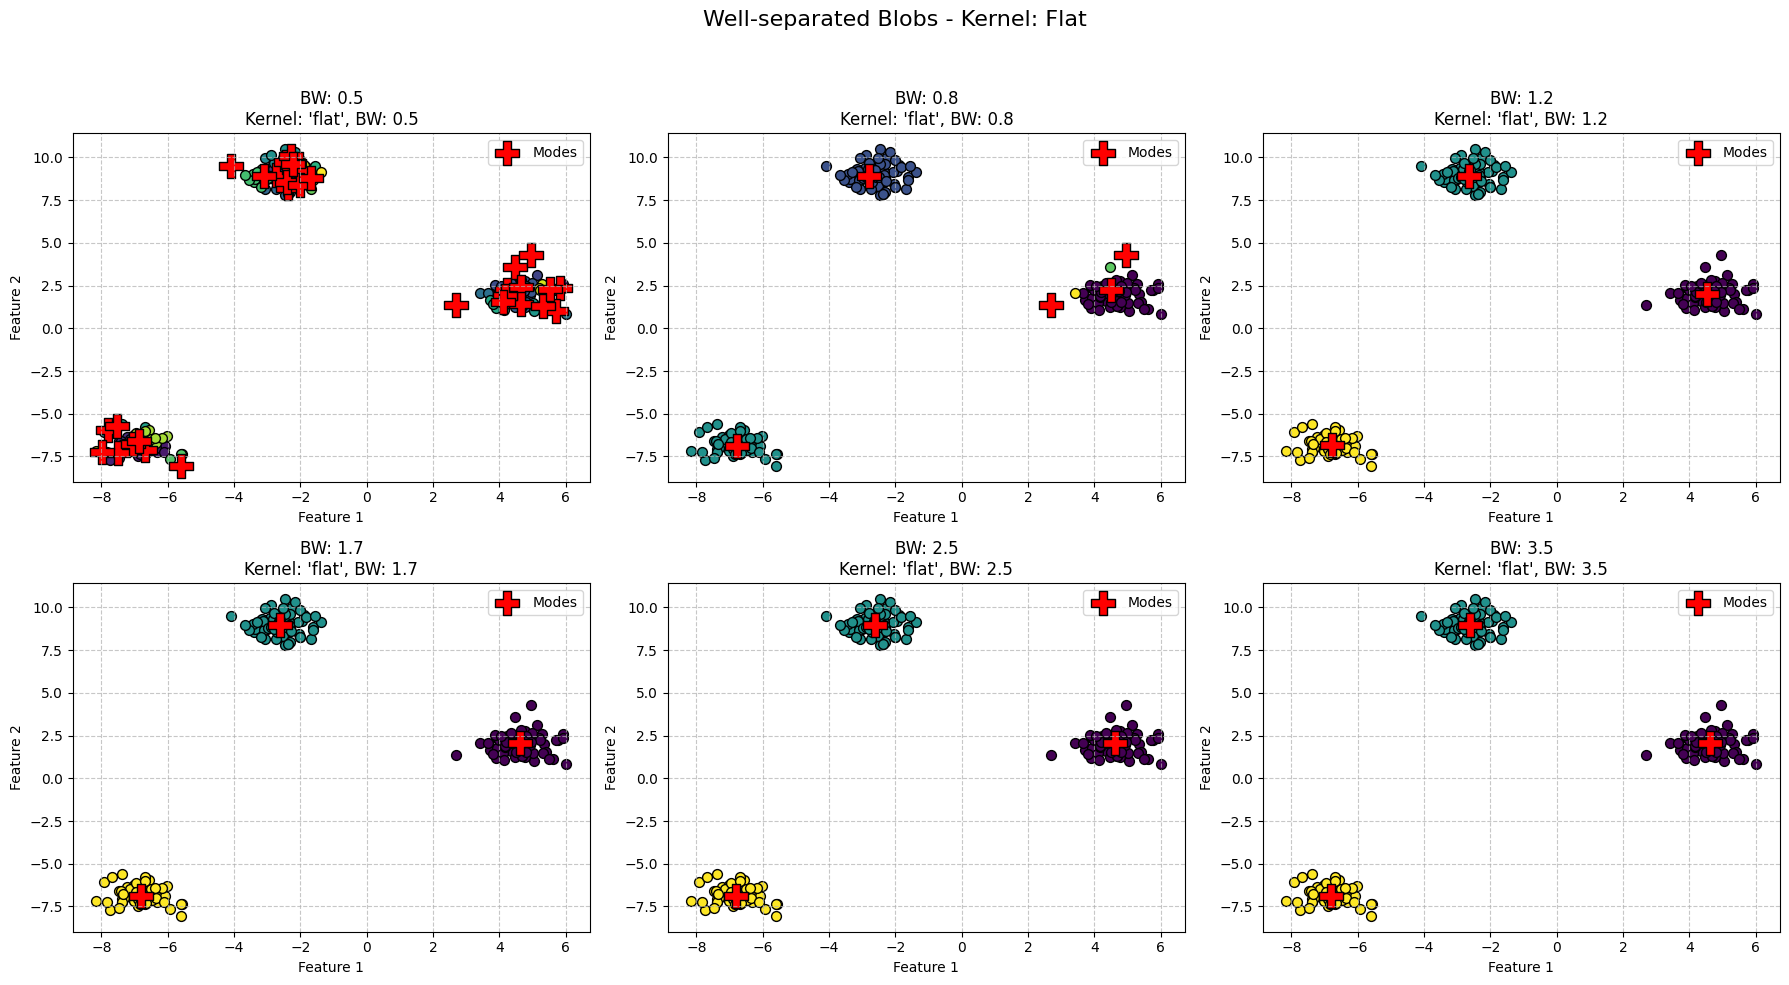

In [19]:
# A. Well-separated Blobs & Bandwidth Variation
print("\n--- Experiment I.A: Well-separated Blobs & Bandwidth Variation ---")
data_blobs_distinct, _ = make_blobs(n_samples=200, centers=3, n_features=2,
                                    cluster_std=0.6, random_state=42)

bandwidths_to_test = [0.5, 0.8, 1.2, 1.7, 2.5, 3.5]
kernels_to_test = ['gaussian', 'flat']

for kernel in kernels_to_test:
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.ravel()
    fig.suptitle(f"Well-separated Blobs - Kernel: {kernel.capitalize()}", fontsize=16)
    for i, bw in enumerate(bandwidths_to_test):
        run_and_plot_mean_shift(data_blobs_distinct, bandwidth=bw, kernel=kernel, ax=axs[i], title_prefix=f"BW: {bw}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


--- Experiment I.B: Overlapping Blobs & Bandwidth Variation ---
Found 85 clusters for BW: 0.3 with kernel 'gaussian'.


<ipython-input-18-d0b8948170f1>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, max(2,len(unique_labels)))


Found 8 clusters for BW: 0.7 with kernel 'gaussian'.
Found 4 clusters for BW: 1.0 with kernel 'gaussian'.
Found 4 clusters for BW: 1.5 with kernel 'gaussian'.
Found 4 clusters for BW: 2.0 with kernel 'gaussian'.
Found 3 clusters for BW: 3.0 with kernel 'gaussian'.


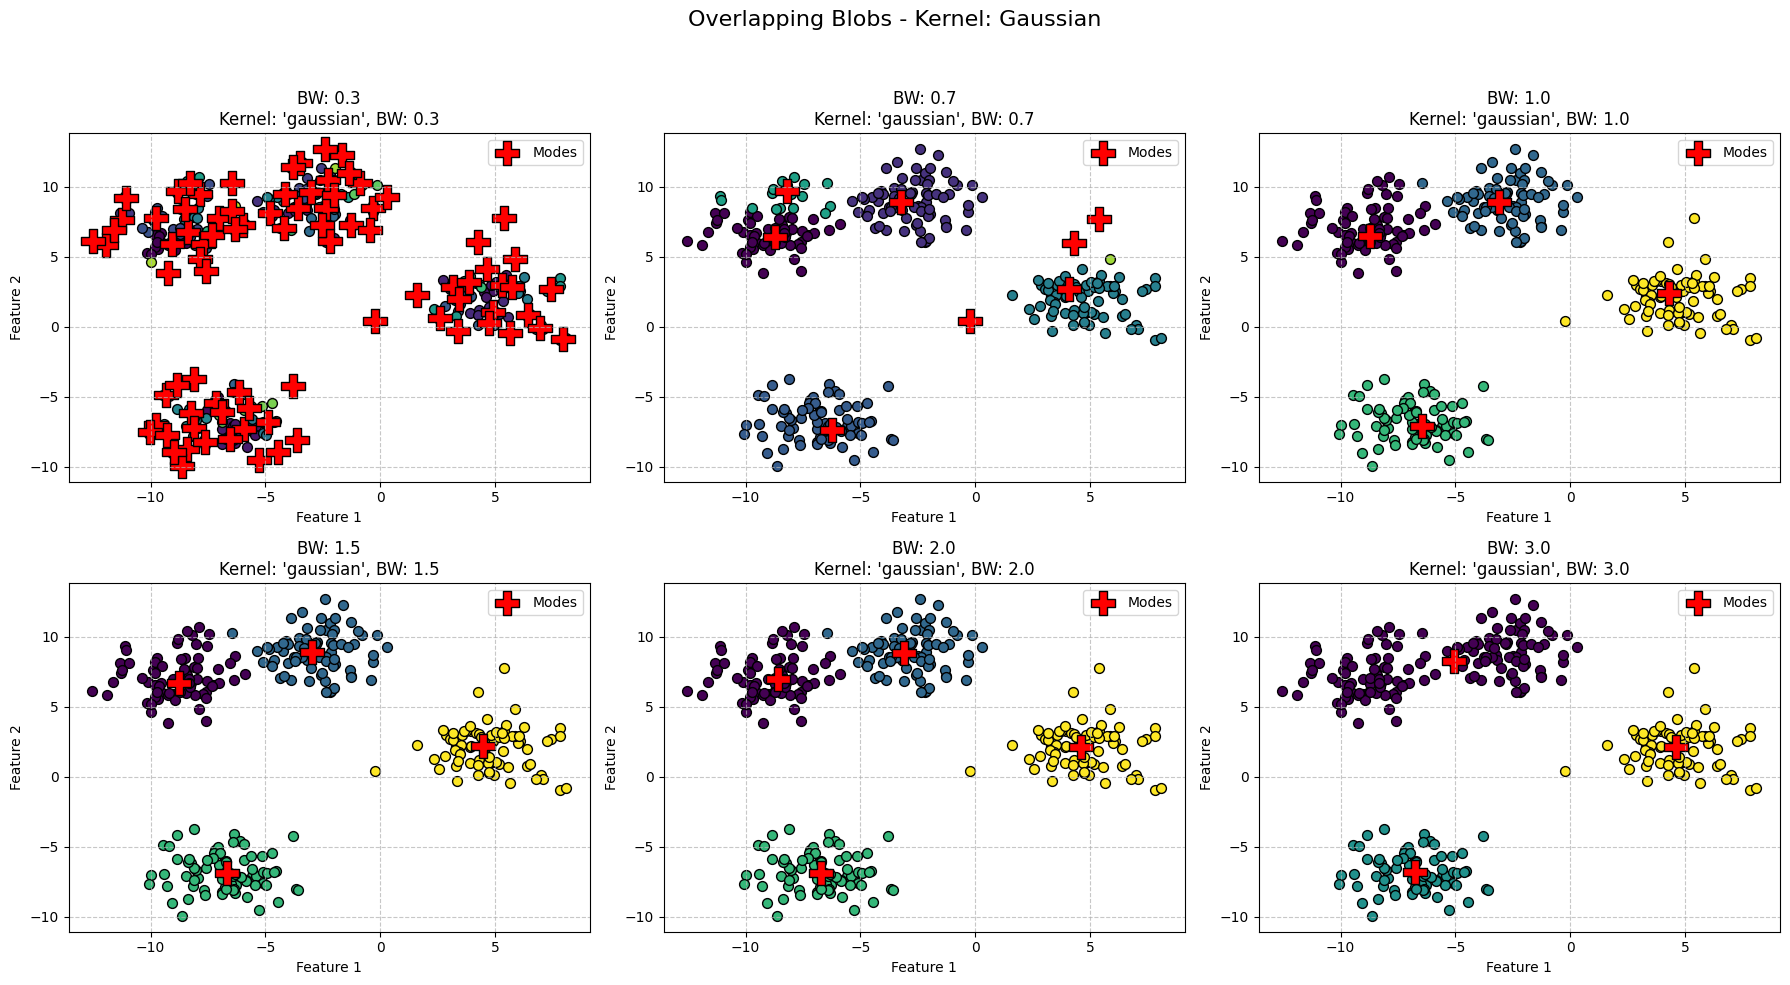

Found 208 clusters for BW: 0.3 with kernel 'flat'.
Found 109 clusters for BW: 0.7 with kernel 'flat'.
Found 71 clusters for BW: 1.0 with kernel 'flat'.
Found 14 clusters for BW: 1.5 with kernel 'flat'.
Found 7 clusters for BW: 2.0 with kernel 'flat'.
Found 4 clusters for BW: 3.0 with kernel 'flat'.


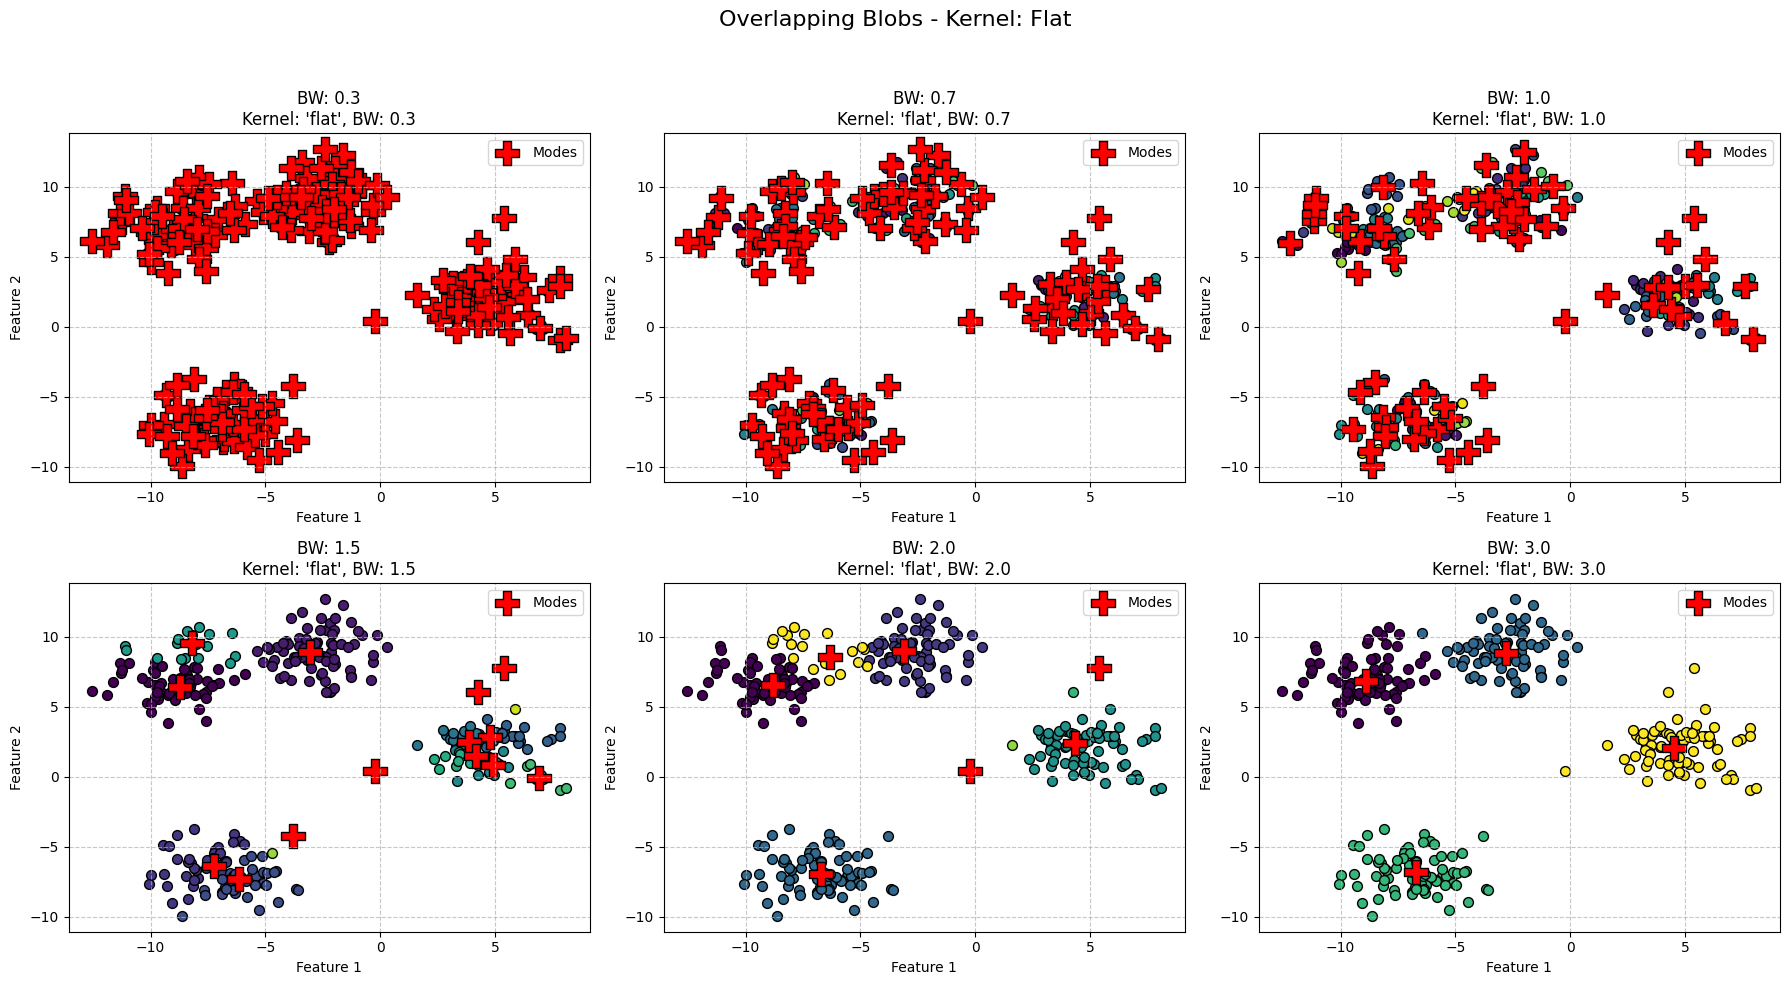

In [30]:
# B. Overlapping Blobs & Bandwidth Variation
print("\n--- Experiment I.B: Overlapping Blobs & Bandwidth Variation ---")
data_blobs_overlap, _ = make_blobs(n_samples=300, centers=4, n_features=2,
                                    cluster_std=1.5, random_state=42)

bandwidths_overlap = [0.3, 0.7, 1.0, 1.5, 2.0, 3.0]
kernels_to_test = ['gaussian', 'flat']

for kernel in kernels_to_test:
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.ravel()
    fig.suptitle(f"Overlapping Blobs - Kernel: {kernel.capitalize()}", fontsize=16)
    for i, bw in enumerate(bandwidths_overlap):
        run_and_plot_mean_shift(data_blobs_overlap, bandwidth=bw, kernel=kernel, ax=axs[i], title_prefix=f"BW: {bw}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


--- Experiment I.C: Non-Globular Shapes (Moons) & Bandwidth Variation ---
Found 8 clusters for BW: 0.2 with kernel 'gaussian'.


<ipython-input-11-d0b8948170f1>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, max(2,len(unique_labels)))


Found 5 clusters for BW: 0.3 with kernel 'gaussian'.
Found 2 clusters for BW: 0.4 with kernel 'gaussian'.
Found 3 clusters for BW: 0.45 with kernel 'gaussian'.
Found 2 clusters for BW: 0.5 with kernel 'gaussian'.
Found 1 clusters for BW: 0.6 with kernel 'gaussian'.


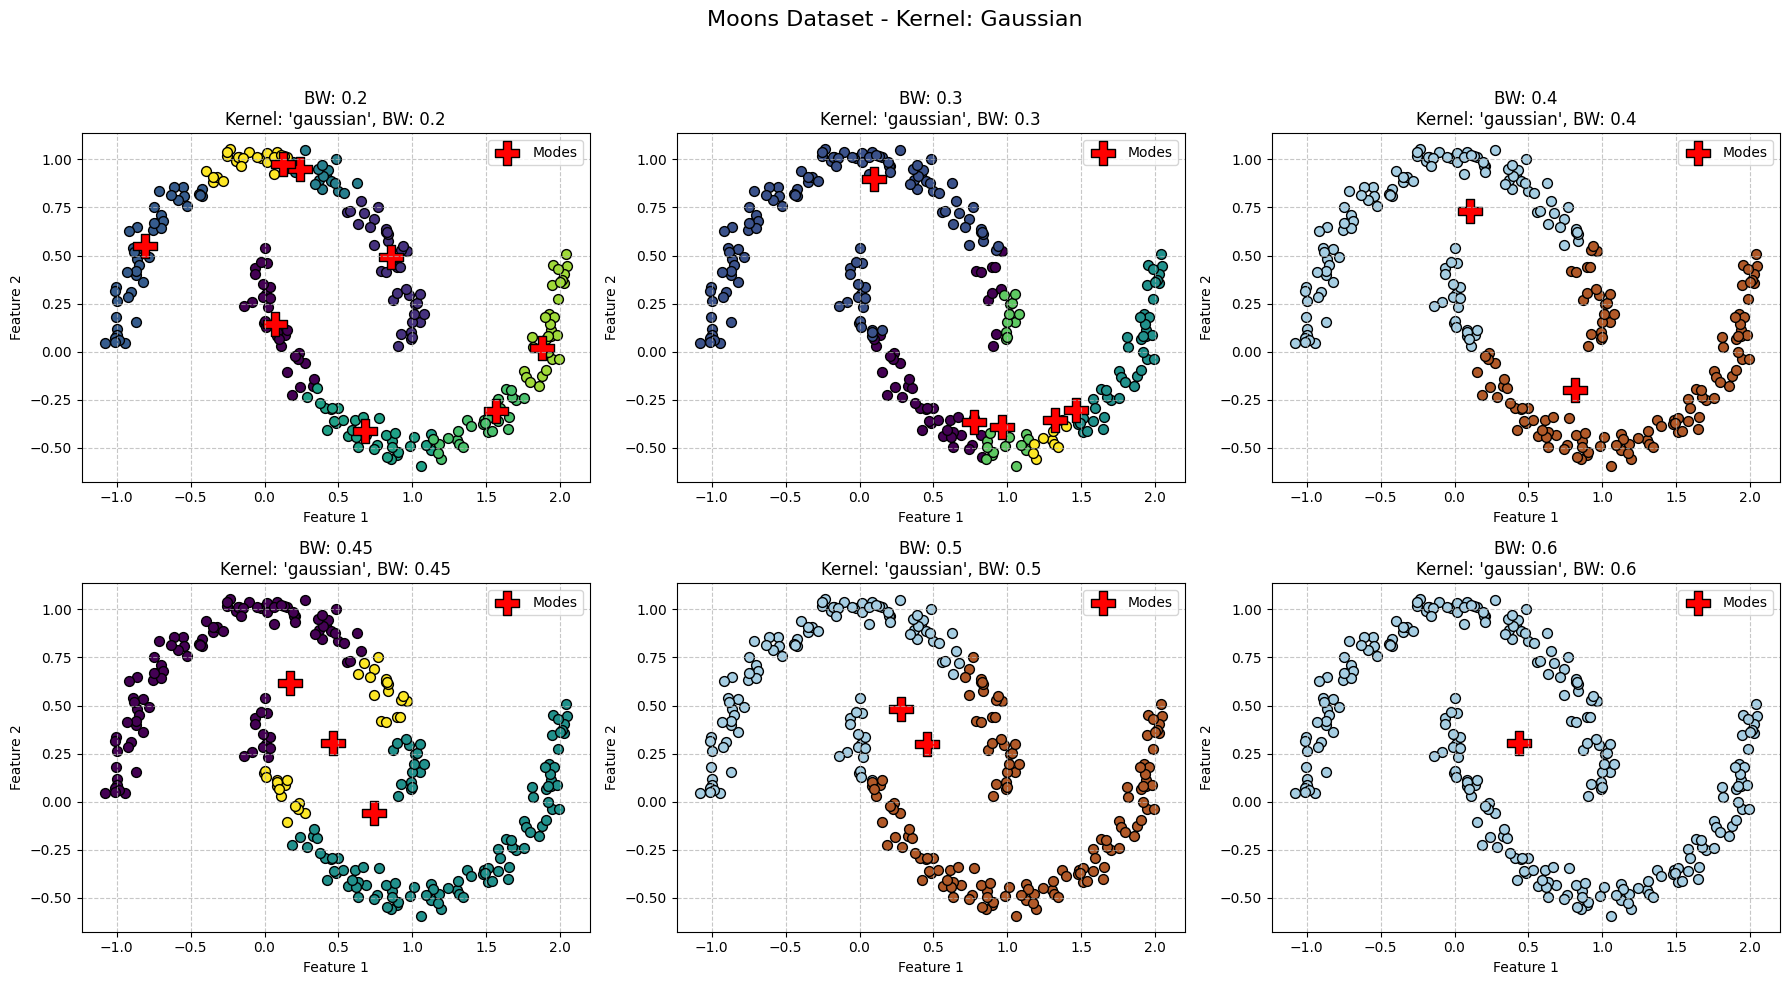

Found 33 clusters for BW: 0.2 with kernel 'flat'.
Found 24 clusters for BW: 0.3 with kernel 'flat'.
Found 17 clusters for BW: 0.4 with kernel 'flat'.
Found 15 clusters for BW: 0.45 with kernel 'flat'.
Found 12 clusters for BW: 0.5 with kernel 'flat'.
Found 9 clusters for BW: 0.6 with kernel 'flat'.


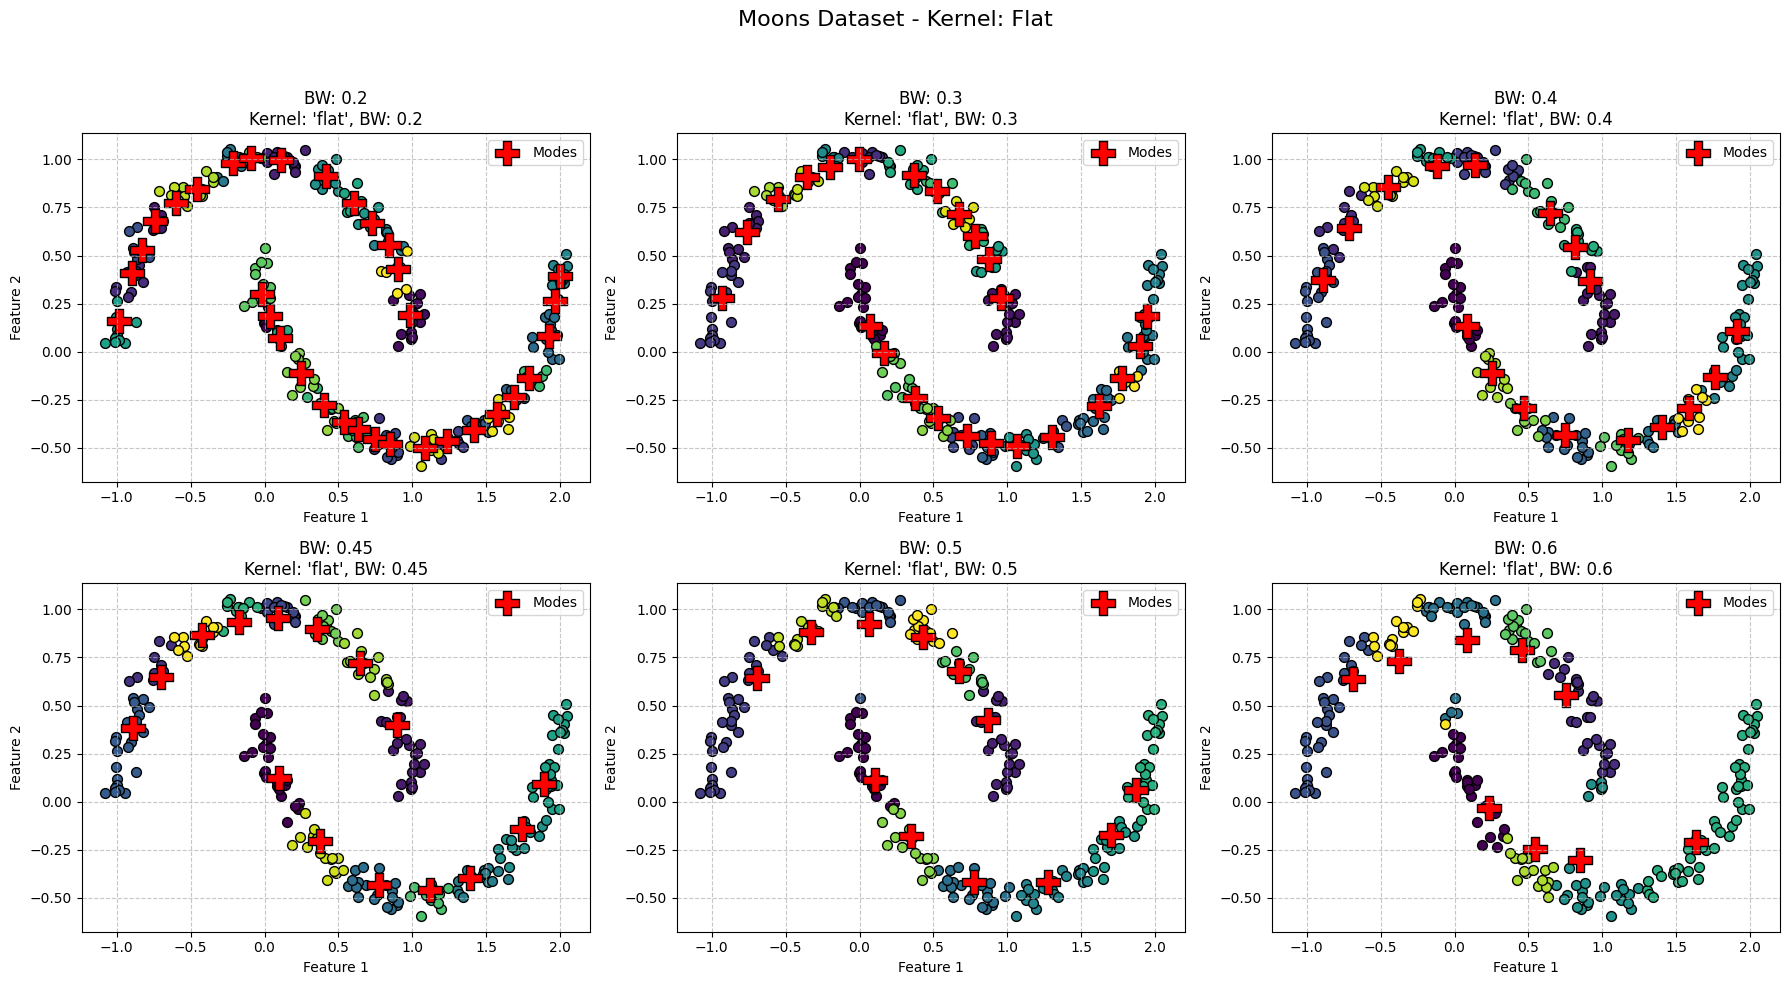

In [23]:
# C. Non-Globular Shapes (Moons) & Bandwidth Variation
print("\n--- Experiment I.C: Non-Globular Shapes (Moons) & Bandwidth Variation ---")
data_moons, _ = make_moons(n_samples=250, noise=0.05, random_state=42)

bandwidths_moons = [0.2, 0.3, 0.4, 0.45, 0.5, 0.6]
kernels_to_test = ['gaussian', 'flat']

for kernel in kernels_to_test:
    fig, axs = plt.subplots(2, 3, figsize=(18, 10))
    axs = axs.ravel()
    fig.suptitle(f"Moons Dataset - Kernel: {kernel.capitalize()}", fontsize=16)
    for i, bw in enumerate(bandwidths_moons):
        run_and_plot_mean_shift(data_moons, bandwidth=bw, kernel=kernel, ax=axs[i], title_prefix=f"BW: {bw}")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


--- Experiment II.A: Minibatch Mean Shift ---
Found 22 clusters for Batch: 50 with kernel 'gaussian'.
Minibatch Size: 50, Execution Time: 23.4500 seconds


<ipython-input-11-d0b8948170f1>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, max(2,len(unique_labels)))


Found 12 clusters for Batch: 100 with kernel 'gaussian'.
Minibatch Size: 100, Execution Time: 43.4375 seconds
Found 4 clusters for Batch: 200 with kernel 'gaussian'.
Minibatch Size: 200, Execution Time: 84.4065 seconds
Found 4 clusters for Batch: 300 with kernel 'gaussian'.
Minibatch Size: 300, Execution Time: 124.6726 seconds


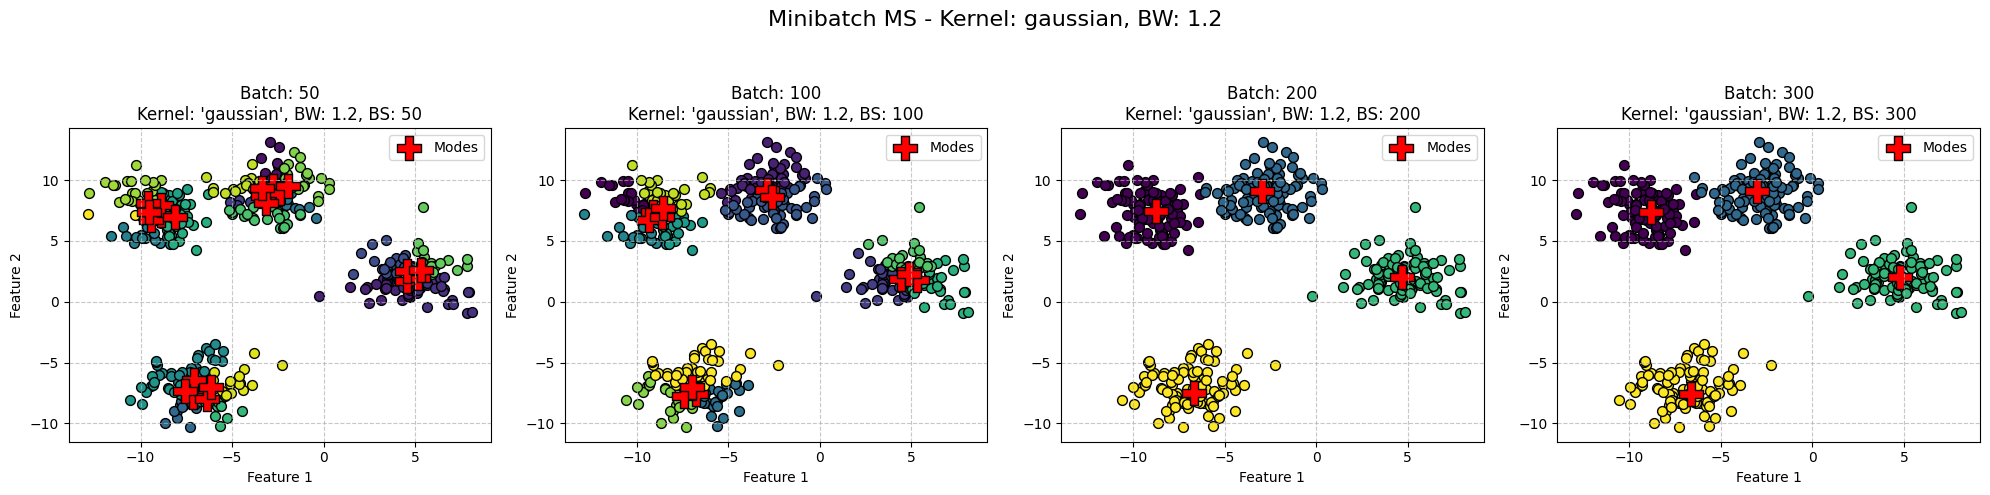

In [12]:
print("\n--- Experiment II.A: Minibatch Mean Shift ---")
data_for_minibatch, _ = make_blobs(n_samples=400, centers=4, n_features=2, # Larger dataset
                                    cluster_std=1.5, random_state=42)
fixed_bandwidth_mb = 1.2
fixed_kernel_mb = 'gaussian'
batch_sizes_to_test = [50, 100, 200, 300]

fig, axs = plt.subplots(1, len(batch_sizes_to_test), figsize=(5 * len(batch_sizes_to_test), 5))
if len(batch_sizes_to_test) == 1: axs = [axs] # Ensure axs is iterable
fig.suptitle(f"Minibatch MS - Kernel: {fixed_kernel_mb}, BW: {fixed_bandwidth_mb}", fontsize=16)
for i, bs in enumerate(batch_sizes_to_test):
    start_time = time.time()
    run_and_plot_mean_shift(data_for_minibatch, bandwidth=fixed_bandwidth_mb,
                            kernel=fixed_kernel_mb, ax=axs[i],
                            title_prefix=f"Batch: {bs}", batch_size=bs, random_seed=123)
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Minibatch Size: {bs}, Execution Time: {execution_time:.4f} seconds")

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


--- Experiment II.B: Weighted Points Mean Shift ---
Found 1 clusters for No Weights with kernel 'gaussian'.


<ipython-input-11-d0b8948170f1>:27: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, max(2,len(unique_labels)))


Found 2 clusters for Emphasize Distinct with kernel 'gaussian'.
Found 1 clusters for Emphasize One Only with kernel 'gaussian'.


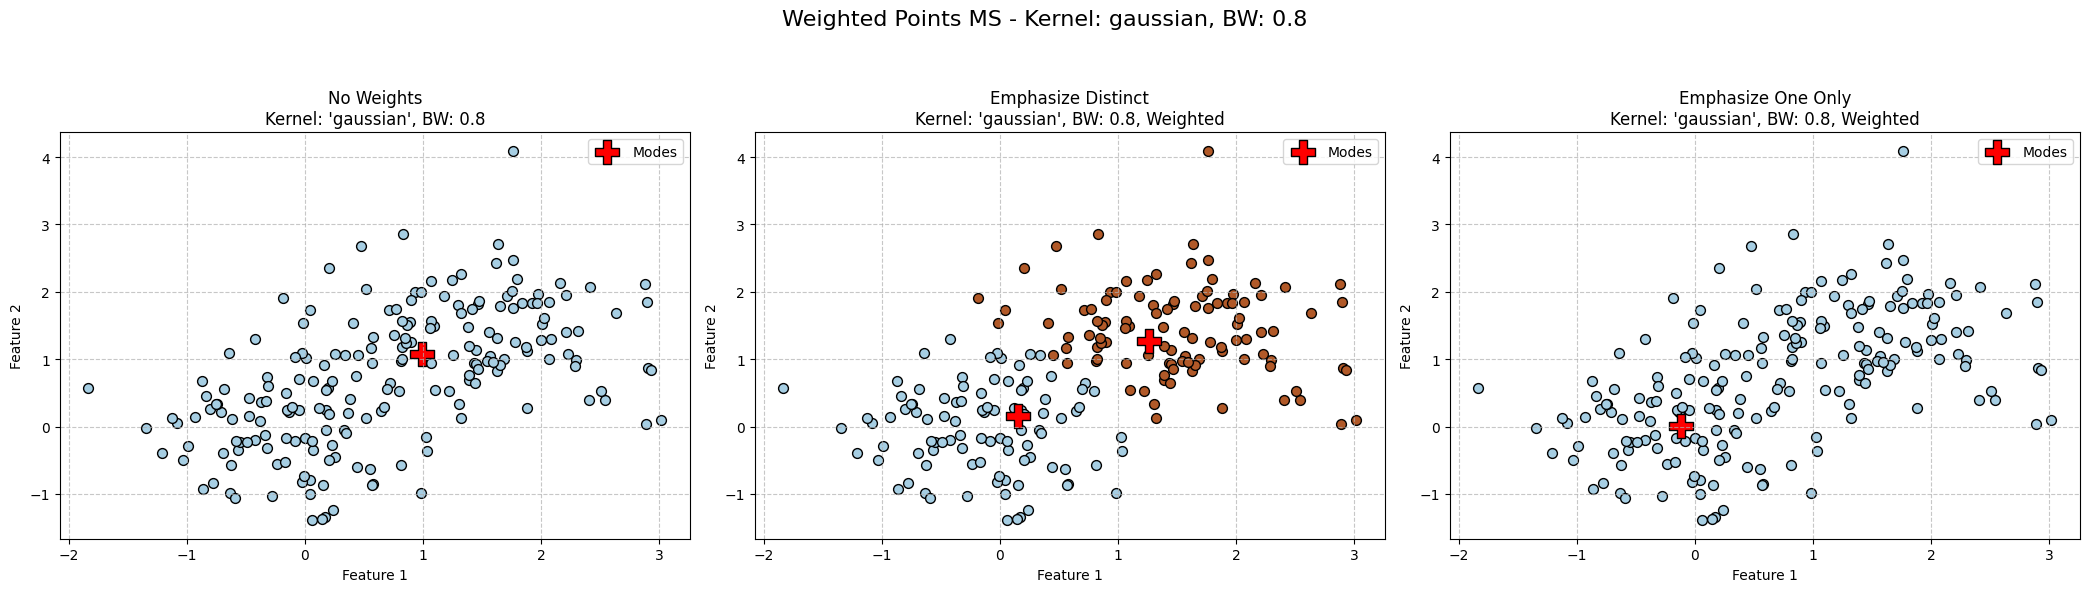

In [67]:
print("\n--- Experiment II.B: Weighted Points Mean Shift ---")
# Create data with two close/slightly overlapping clusters
blob_centers = np.array([[0,0], [1.4, 1.4]])
blob_std = 0.7
data_for_weights, true_labels_weights = make_blobs(n_samples=200,
                                                    centers=blob_centers,
                                                    cluster_std=blob_std,
                                                    random_state=42)
noise_std = 0.5
noise = np.random.randn(*data_for_weights.shape) * noise_std
noised_data_for_weights = data_for_weights + noise

n_samples_wp = noised_data_for_weights.shape[0]

# Choose a bandwidth that might be ambiguous without weights
fixed_bandwidth_wp = 0.8
fixed_kernel_wp = 'gaussian'

# Weighting Scheme 1: No weights (baseline)
weights_none = None

# Weighting Scheme 2: Emphasize the two clusters distinctly
weights_emphasize_cores = np.ones(n_samples_wp)
high_weight_value = 20.0
core_radius_threshold = 0.2

for i in range(n_samples_wp):
    point = data_for_weights[i]
    true_label = true_labels_weights[i] # 0 or 1

    # Calculate distance to its own true center
    if true_label == 0:
        distance_to_own_center = euclidean_distance(point, blob_centers[0])
    elif true_label == 1:
        distance_to_own_center = euclidean_distance(point, blob_centers[1])

    if distance_to_own_center < core_radius_threshold:
        weights_emphasize_cores[i] = high_weight_value

# Weighting Scheme 3: Emphasize only the first cluster
weights_emphasize_one_cluster = np.ones(n_samples_wp)
weights_emphasize_one_cluster[true_labels_weights == 0] = 20.0
weights_emphasize_one_cluster[true_labels_weights == 1] = 0.5 # Downplay the second


weighting_schemes = [
    {"name": "No Weights", "weights": weights_none},
    {"name": "Emphasize Distinct", "weights": weights_emphasize_cores},
    {"name": "Emphasize One Only", "weights": weights_emphasize_one_cluster}
]

fig, axs = plt.subplots(1, len(weighting_schemes), figsize=(7 * len(weighting_schemes), 6))
if len(weighting_schemes) == 1: axs = [axs]
fig.suptitle(f"Weighted Points MS - Kernel: {fixed_kernel_wp}, BW: {fixed_bandwidth_wp}", fontsize=16)

for i, scheme in enumerate(weighting_schemes):
    run_and_plot_mean_shift(data_for_weights, bandwidth=fixed_bandwidth_wp,
                            kernel=fixed_kernel_wp, ax=axs[i],
                            title_prefix=scheme["name"], point_weights=scheme["weights"])
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()